## Proyecto Vision Artificial: Cat VS Dog
#### Proyecto realizado por Daniel Pérez e Iván Sola

In [1]:
import numpy as np
import cv2
import pandas as pd
import os
from matplotlib import pyplot as plt
from skimage.transform import resize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


def LeerCarpetas(ruta_train, ruta_test):

- ruta_train: ruta de la carpeta de los ejemplos de train

- ruta_test: ruta de la carpeta de los ejemplos de test 

Devuelve todos los nombres de las imagenes tanto de train como de test en dos listas de strings

In [2]:
def LeerCarpetas(ruta_train, ruta_test):
    path_train, dirs_train, files_train = next(os.walk(ruta_train))
    file_count_train = len(files_train)
    print("Numero de imagenes en cada carpeta en train: ",file_count_train)
    for i in range (len(files_train)):
        files_train[i] = ruta_train + "/" + files_train[i] 

    path_test, dirs_test, files_test = next(os.walk(ruta_test))
    file_count_test = len(files_test)
    print("Numero de imagenes en cada carpeta en test: ",file_count_test , "\n")
    for i in range (len(files_test)):
        files_test[i] = ruta_test + "/" + files_test[i] 
    return files_train, files_test


#### def calcularDimensionMedia(ejemplos):
    
- ejemplos: parámetro que dispone de una lista de los nombres de imágenes

devuelve la dimension media entre todas las imagenes de esta lista

In [3]:
def calcularDimensionMedia(ejemplos):
    dimensionMedia = np.array([0,0])
    for i in range (len(ejemplos)):
        dimension = cv2.imread(ejemplos[i], cv2.IMREAD_GRAYSCALE).shape
        dimensionMedia = dimensionMedia + dimension
    dimensionMedia = dimensionMedia//len(ejemplos)
    return dimensionMedia

#### def redimensionarImagen(imagenOriginal, tamañoBloque, dimension):
- imagenOriginal : parametro que contiene una imagen
- tamañoBloque : tamaño de los bloques en los que se va a dividir la imagen
- dimension : dimension a la que vamos a redimensionar la imagen

Esta función devuelve una imagen redimensionada con tamaño dimension y también de forma que la matriz de salida sea divisible entre la matriz bloque, asi consiguiendo un numero de bloques justo para la imagen y no tener problemas

In [4]:
#Redimensionamos imagen para que sea divisible entre (numeroBloque x numeroBloque)
def redimensionarImagen(imagenOriginal, tamañoBloque, dimension):
    imagenOriginal = resize(imagenOriginal, (dimension))
    filasImagen, columnasImagen = imagenOriginal.shape
    topbottom = int(tamañoBloque - filasImagen%tamañoBloque)
    leftright = int (tamañoBloque - columnasImagen%tamañoBloque)
    if (topbottom%2 == 0 and leftright%2 == 0):
        imagen_ampliada = cv2.copyMakeBorder(imagenOriginal, topbottom//2, topbottom//2, leftright//2, leftright//2, cv2.BORDER_REPLICATE)
    elif (topbottom%2 == 1 and leftright%2 == 1):
        imagen_ampliada = cv2.copyMakeBorder(imagenOriginal, (topbottom//2)+1, topbottom//2, (leftright//2)+1, leftright//2, cv2.BORDER_REPLICATE)
    elif (topbottom%2 == 1 and leftright%2 == 0):
        imagen_ampliada = cv2.copyMakeBorder(imagenOriginal, (topbottom//2)+1, topbottom//2, leftright//2, leftright//2, cv2.BORDER_REPLICATE)
    else:
        imagen_ampliada = cv2.copyMakeBorder(imagenOriginal, topbottom//2, topbottom//2, (leftright//2+1), leftright//2, cv2.BORDER_REPLICATE)
    print("El tamaño de la imagen final es: ", imagen_ampliada.shape)
    print("numero de bloques", imagen_ampliada.size/(tamañoBloque*tamañoBloque))
    return imagen_ampliada
    

#### def divisionImagen(imagen_ampliada, tamañoBloque):
- imagen_ampliada: imagen conseguida con la anterior función
- tamañoBloque: tamaño del bloque en la que se va a dividir la imagen

Devuelve una imagen dividia en tantos bloques como imagen_ampliada.size/(tamañoBloque*tamañoBloque)

In [5]:
#Dividimos imagen en bloques de (numeroBloque X numeroBloque)
def divisionImagen(imagen_ampliada, tamañoBloque):
    tamañoImagen = imagen_ampliada.size
    filasImagen, columnasImagen = imagen_ampliada.shape
    numeroBloques = int(imagen_ampliada.size/(tamañoBloque*tamañoBloque))
    imagenDividida = np.zeros(shape=[numeroBloques, tamañoBloque, tamañoBloque])
    cont = 0
    for i in (np.arange(0, filasImagen, tamañoBloque)):
        for j in (np.arange(0, columnasImagen, tamañoBloque)):
            imagenDividida[cont] = imagen_ampliada[i:(i+tamañoBloque), j:(j+tamañoBloque)]
            cont+=1
    return imagenDividida


#### def convertirBinarioADecimal (binario):
- binario: parámetro que es un numero binario que puede ser tanto un string como un entero. Devolvemos el número decimal de este binario.

devuelve el numero en decimal

In [6]:
#Función que le pasas un número binario, ya sea en modo int o string y te lo pasa a decimal
def convertirBinarioADecimal (binario):
    binario = str(binario)
    suma = 0
    for i in range (len(binario)-1,-1, -1):
        if (binario[len(binario)-i-1] == '1'):
            suma = suma + (2**i)
    return suma


#### def modificarPixeles(bloque):
- bloque: parámetro que será una celda correspoendente a una imagen ya dividida

devuelve un bloqueModificado en el que tratamos los vecinos de cada pixel de este bloque y transformamos este pixel en el número binario que forman sus vecinos, siendo 1 cuando un vecino mayor y un 0 cuando es menor del pixel central. Así empezando por el pixel de arriba y recorriéndolo al contrario de las agujas del reloj para conseguir un número binario que después transformaremos a decimal con la función definida anteriormente

In [7]:
#Funcion que modifica los píxeles de la imagen que realiza el algoritmo que sacará el número binario entre los vecinos del pixel que estemos tratando
# Si los vecinos son mayores que el pixel central será 1 y si no 0, la forma de recorrerlo para hallar el número binario es empezar por el de arriba del
# pixel que estamos tratando y siguiendo al contrario de las agujas del reloj
def modificarPixeles(bloque):
    filasBloque, columnasBloque = bloque.shape
    bloqueModificado = np.zeros(shape=bloque.shape)
    bloque = cv2.copyMakeBorder(bloque, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

    for i in range (1, filasBloque+1):
        for j in range (1, columnasBloque+1):
            vectorVecinos = np.array([bloque[i+1,j], bloque[i+1,j-1], bloque[i,j-1] , bloque[i-1,j-1], bloque[i-1,j], bloque[i-1,j+1], bloque[i,j+1], bloque[i+1,j+1]])
            binario = np.int64(vectorVecinos >= bloque[i][j])
            bloqueModificado[i-1][j-1] = convertirBinarioADecimal(repr(binario[0])+repr(binario[1])+repr(binario[2])+repr(binario[3])+repr(binario[4])+repr(binario[5])+repr(binario[6])+repr(binario[7]))
    return bloqueModificado

#### def calcCaracteristicas(bloquesModificados):

- bloquesModificados: matriz tridimensional que contiene el número de bloques modificados obtenidos de la función anterior

devuelve un parámetro caract que almacena todas las características de cada bloque, siendo cada una de estas el histograma correspondiente para ese bloque entre el pixel 0 y 256, es decir cada vector características tiene un tamaño de 256.

In [8]:
#Función que calcula las características de la imagen a partir de los bloques modificados
# Calculamos el histograma de cada bloque y concatenamos todos en orden de bloque
def calcCaracteristicas(bloquesModificados):
    bloquesModificados = np.uint8(bloquesModificados)
    numeroBloques, filasBloques, columnasBloques = bloquesModificados.shape
    caract = np.array([])
    for i in range (int(numeroBloques)):
        h = cv2.calcHist([bloquesModificados[i]], [0], None, [256], [0,256])
        caract = np.concatenate((caract, h.ravel()))
    return np.uint8(caract)

#### def calcCaracterísticas2(bloquesModificados):
    
Funcion que calcula las características de una segunda forma (No es usada)

In [9]:
#Función que no utilizamos, calcula las características de una forma concreta
def calcCaracterísticas2(bloquesModificados):
    bloquesModificados = np.uint8(bloquesModificados)
    numeroBloques, filasBloques, columnasBloques = bloquesModificados.shape
    bloquesCaract = np.zeros(shape = bloquesModificados.shape)
    for i in range (int(numeroBloques)):
        h = cv2.calcHist([bloquesModificados[i]], [0], None, [256], [0,256])
        bloquesCaract[i] = h[bloquesModificados[i]].reshape([filasBloques,columnasBloques])
    return bloquesCaract

#### def filtro(imagen, mascara):

Funcion que calcula el filtro de una mascara (no utilizada)

In [10]:
def filtro(imagen, mascara):
    dim = imagen.ndim
    shape = imagen.shape
    print(mascara.shape)
    filasMascara = mascara.shape[0]//2
    columnasMascara = mascara.shape[1]//2

    imagen_ampliada = cv2.copyMakeBorder(imagen, filasMascara, filasMascara, columnasMascara, columnasMascara, cv2.BORDER_REPLICATE)
    imagen_ampliada = np.array(imagen_ampliada, dtype=np.float64)

    imagen2 = np.zeros(shape)
    imagen2 = np.array(imagen2, dtype=np.float64)

    for i in range (filasMascara,(shape[0] + filasMascara)):
        for j in range (columnasMascara,(shape[1] + columnasMascara)):
            imagen2[i - filasMascara][j - columnasMascara] = np.sum(np.multiply(imagen_ampliada[(i-filasMascara):(i+filasMascara+1),(j-columnasMascara):(j+columnasMascara+1)], mascara))
    return imagen2


#### def filtro_x(imagen, mascara):

Funcion que calcula el filtrado de la imagen de una máscara vector, como por ejemplo (-1, 0, 1) siendo esta un vector 1x3

In [11]:
def filtro_x(imagen, mascara):
    dim = imagen.ndim
    filas, columnas = imagen.shape
    
    tamañoVector = mascara.size//2

    imagen_ampliada = cv2.copyMakeBorder(imagen, 0, 0, tamañoVector, tamañoVector, cv2.BORDER_REPLICATE)
    imagen_ampliada = np.array(imagen_ampliada, dtype=np.uint8)

    imagen2 = np.zeros(shape=[filas, columnas])

    for i in range (filas):
        for j in range (tamañoVector, columnas+tamañoVector):
            imagen2[i][j-tamañoVector] = np.sum(np.multiply(imagen_ampliada[i, (j-tamañoVector):(j+tamañoVector+1)], mascara))
    return imagen2


#### def filtro_y(imagen, mascara):
    
Funcion que calcula el filtro de la imagen de la máscaray (-1, 0, 1), siendo esta un vector 3x1

In [12]:
def filtro_y(imagen, mascara):
    dim = imagen.ndim
    filas, columnas = imagen.shape
    tamañoVector = mascara.size//2

    imagen_ampliada = cv2.copyMakeBorder(imagen, tamañoVector, tamañoVector, 0, 0, cv2.BORDER_REPLICATE)
    imagen_ampliada = np.array(imagen_ampliada, dtype=np.uint8)

    imagen2 = np.zeros(shape=[filas, columnas])

    for i in range (tamañoVector, filas + tamañoVector):
        for j in range(columnas):
            imagen2[i-tamañoVector][j] = np.sum(np.multiply(imagen_ampliada[(i-tamañoVector):(i+tamañoVector+1), j], mascara.ravel()))
    return imagen2

#### def gradiente(imagen):

- imagen: matriz bidimensional que representa una imagen

devuelve la imagen de magnitudes y la imagen de orientaciones usando las dos funciones de filtrado anteriores

In [13]:
def gradiente(imagen):
    m_g_x = np.array([-1,0,1])
    m_g_y = np.array([[-1], [0], [1]])

    imagenx = filtro_x(imagen, m_g_x)
    imageny = filtro_y(imagen, m_g_y)
    
    ##Imagen de magnitudes
    E = np.sqrt(np.power(imagenx, 2) + np.power(imageny, 2))

    #Imagen de orientación
    Phi = np.arctan2(imagenx, imageny)
    
    return E, np.rad2deg(Phi)

#### def calcularHist(Phi, E):
- Phi: imagen de orientaciones de un bloque o celda
- E: imagen de magnitudes de un bloque o celda
 
devuelve un histograma, el cual es un vector de tamaño 9 obtenido de un bloque de la imagen que estemos tratando, de forma que por ejemplo en la posicion histograma[i] encontraremos la suma de magnitudes de todos los pixeles que pertenecen a la clase i de las orientaciones. En mi caso entre -20 grados y 20 grados es clase 1, entre 40 y 20, y, entre -20 y -40 es clase 2 etc.

In [14]:
def calcularHist(Phi, E):
    shapePhi = Phi.shape
    Phi_discretizado = np.zeros(shapePhi)
    hist = np.zeros(9)
    for i in range (shapePhi[0]):
        for j in range (shapePhi[1]):
            grado = Phi[i][j]
            if (-20 <= grado <= 20):
                hist[0] += E[i][j] 
            elif ((-20 >= grado >= -40) or (20 <= grado >= 40)):
                hist[1] += E[i][j]
            elif ((-40 >= grado >= -60) or (40 <= grado <= 60)):
                hist[2] += E[i][j]
            elif ((-60 >= grado >= -80) or (60 <= grado <= 80)):
                hist[3] += E[i][j]
            elif ((-80 >= grado >= -100) or (80 <= grado <= 100)):
                hist[4] += E[i][j]
            elif ((-100 >= grado >= -120) or (100 <= grado <= 120)):
                hist[5] += E[i][j]
            elif ((-120 >= grado >= -140) or (120 <= grado <= 140)):
                hist[6] += E[i][j]
            elif ((-140 >= grado >= -160) or (140 <= grado <= 160)):
                hist[7] += E[i][j]
            elif ((-160 >= grado >= -180) or (160 <= grado <= 180)):
                hist[8] += E[i][j]
    return hist


#### def normalizarHist(hist):

Devuelve el histograma normalizado mediante la norma de euclides

In [15]:
def normalizarHist(hist):
    if (np.sum(hist) == 0):
        return hist
    else:
        return hist/np.sqrt(np.sum(np.power(hist,2)))

### Extracción de carácterísticas 1
1. En primer lugar redimensionamos la imagen, en base a una dimension introducida, para que
así, todas las imágenes dispongan del mismo tamaño y no tengamos problemas a la hora de trabajar
con sus características.
2. Dividimos la imagen en bloques disjuntos de NxN píxeles (por ejemplo, N = 16). A estos
bloques les llamaremos celdas. Es decir, ahora trabajaremos sobre una matriz tridimensional
de (numeroDeBloques)x(tamañoBloque)x(tamañoBloque)
3. Para cada píxel de la celda, lo vamos a comparar con cada uno de sus 8 vecinos,
empezando, por ejemplo, por el de arriba a la izquierda y siguiendo la dirección al contrario
de las agujas del reloj.
4. Los valores de los 8 vecinos los vamos a sustituir por un 0 o un 1 en función de si el
vecino es menor (0) o mayor (1) que el píxel central.
5. Una vez realizado este cambio, si tomamos el valor de los 8 vecinos siguiendo la misma
distribución que en el paso anterior, nos generará un número binario que, al
transformarlo a decimal, resultará en un número entre 0 y 255
6. Modificaremos el valor del píxel por el del número decimal obtenido.
7. Finalmente obtendremos el histograma obtenido de los bloques que hemos modificado como
hemos explicado anteriormente, y los iremos concatenando en orden de bloque así generando 
un vector de tamaño 1x((numeroDeBloques)x256), que resultará ser el vector de características
de la imagen.

#### def extraccionCaracteristicas1(imagenOriginal, tamañoBloque, dimension):

Primera forma de extraccion de características

In [16]:
#Realiza todo el proceso de extracción de características con ayuda de las funciones definidas anteriormente
def extraccionCaracteristicas1(imagenOriginal, tamañoBloque, dimension):
    imagen_ampliada = redimensionarImagen(imagenOriginal, tamañoBloque, dimension)
    imagenDividida = divisionImagen(imagen_ampliada, tamañoBloque)
    bloquesModificados = np.zeros(shape=imagenDividida.shape)
    for i in range (imagenDividida.shape[0]):
        bloquesModificados[i] = modificarPixeles(imagenDividida[i])
    caract = calcCaracteristicas(bloquesModificados)
    return (caract)

### Extracción de carácterísticas 2 
1. En primer lugar redimensionamos la imagen, en base a una dimension introducida, para que
así, todas las imágenes dispongan del mismo tamaño y no tengamos problemas a la hora de trabajar
con sus características.
2. Aplicar un filtro espacial de aproximación de la derivada parcial en ambas direcciones
mediante las máscaras de convolución (−1,0,1) y (−1,0,1), siendo la primera la mascara para x 
y un vector de 1x3 y la segunda la mascara de y, vector de 3x1
3. Calculamos la magnitud y orientación de gradiente de la imagen
4. Dividir la imagen, tanto de magnitudes como de orientaciones en bloques disjuntos de NxN
píxeles (por ejemplo, N = 16). A estos bloques les llamaremos celdas
5. Calculamos un histograma para cada uno de los bloques. El histograma estará formado
por 9 valores o bins. El primer bin servirá para las orientaciones entre -20
y 20 grados; el segundo para las orientaciones entre 20 y 40 y entre -40 y -20; y así
sucesivamente.
6. Para rellenar el histograma, no vamos a hacer un conteo de cuántas orientaciones hay
en cada bin, sino que rellenaremos el histograma mediante el valor de la magnitud del
gradiente. Por ejemplo, si el primer píxel de la celda tiene orientación 45º, entonces en
el bin asociado a 45º (tercer bin) sumaremos el valor de la magnitud en dicho punto.
Una vez sumadas las magnitudes en cada correspondiente bin, tendremos un vector de
9 valores para cada celda.
7. Vamos a normalizar el histograma, dividiéndolo entre el valor de la norma euclídea de
los 9 valores (raíz cuadrada de la suma al cuadrado de los valores).
8. Finalmente iremos concatenando las características de cada imagen para crear el vector características

#### def extraccionCaracteristicas2(imagenOriginal, tamañoBloque, dimension):

Segunda forma de extracción de características

In [17]:
def extraccionCaracteristicas2(imagenOriginal, tamañoBloque, dimension):
    imagenRedimensionada = redimensionarImagen(imagenOriginal, tamañoBloque, dimension)
    E, Phi = gradiente(imagenRedimensionada)
    EDividido = divisionImagen(E, tamañoBloque)
    PhiDividido = divisionImagen(Phi, tamañoBloque)
    carac = np.array([])
    for i in range (PhiDividido.shape[0]):
        hist = calcularHist(PhiDividido[i], EDividido[i])
        histNormalizado = normalizarHist(hist)
        carac = np.concatenate((carac, histNormalizado)) 
    return (carac)

#### def extraerCaracteristicasImagenes1(nombreFichero, ejemplos, numeroBloque):
- nombreFichero: nombre que vamos a poner a nuestro dataset
- ejemplos: imagenes de las que vamos a tratar y extraer sus características
- numeroBloque: numero de bloque en el que las imagenes se van a dividir

Consiste en crear un dataset.csv con las características de cada ejemplo tratado del primer tipo de extraccion de características

In [18]:
#Almacenamos las características de cada imagen en varios ficheros de texto
import csv
def extraerCaracteristicasImagenes1(nombreFichero, ejemplos, numeroBloque, dimension):
    File = open(nombreFichero, 'w')
    with File:  
        writer = csv.writer(File)
        text = []
        for i in range (len(ejemplos)):
            caract = extraccionCaracteristicas1(cv2.imread(ejemplos[i], cv2.IMREAD_GRAYSCALE), numeroBloque, dimension)
            text.append(caract)
        writer.writerows(text)

#### def extraerCaracteristicasImagenes2(nombreFichero, ejemplos, numeroBloque):

Lo mismo que el anterior pero esta vez con el segundo tipo de extracción de características

In [19]:
#Almacenamos las características de cada imagen en varios ficheros de texto
import csv
def extraerCaracteristicasImagenes2(nombreFichero, ejemplos, numeroBloque, dimension):
    File = open(nombreFichero, 'w')
    with File:  
        writer = csv.writer(File)
        text = []
        for i in range (len(ejemplos)):
            caract = extraccionCaracteristicas2(cv2.imread(ejemplos[i], cv2.IMREAD_GRAYSCALE), numeroBloque, dimension)
            text.append(caract)
        writer.writerows(text)

### COMENZAMOS CON LA EJECUCIÓN DEL PROYECTO
Todos los pasos anteriores a este son funciones definidas que usaremos posteriormente para que el programa funcione

Ejemplo de como mostrar imagen cualquiera

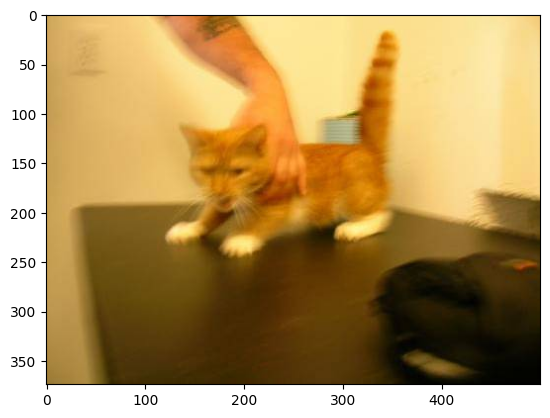

In [20]:
imagen = cv2.imread('cat_dog_100/train/cat/cat.0.jpg', cv2.IMREAD_GRAYSCALE)
imagen_color = cv2.imread('cat_dog_100/train/cat/cat.0.jpg')
imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB) 
#cv2.imshow('Imagen gato', imagen)
plt.imshow(imagen_color)

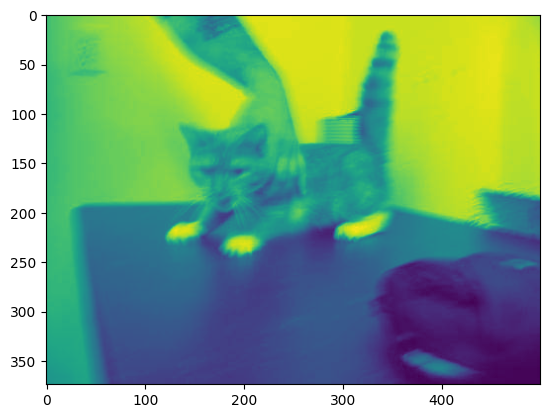

In [21]:
plt.imshow(imagen)

In [22]:
print(imagen_color.shape)
print(imagen.shape)

(374, 500, 3)
(374, 500)


Extracción de los nombres de las imágenes de cada carpeta

Numero de imagenes en cada carpeta

In [23]:
(cat100_train, cat100_test) = LeerCarpetas("cat_dog_100/train/cat", "cat_dog_100/test/cat")
(dog100_train, dog100_test) = LeerCarpetas("cat_dog_100/train/dog", "cat_dog_100/test/dog")
(cat500_train, cat500_test) = LeerCarpetas("cat_dog_500/train/cat", "cat_dog_500/test/cat")
(dog500_train, dog500_test) = LeerCarpetas("cat_dog_500/train/dog", "cat_dog_500/test/dog")

Numero de imagenes en cada carpeta en train:  100
Numero de imagenes en cada carpeta en test:  20 

Numero de imagenes en cada carpeta en train:  100
Numero de imagenes en cada carpeta en test:  20 

Numero de imagenes en cada carpeta en train:  500
Numero de imagenes en cada carpeta en test:  100 

Numero de imagenes en cada carpeta en train:  500
Numero de imagenes en cada carpeta en test:  100 



In [24]:
todosEjemplos = cat100_train + cat100_test + dog100_train + dog100_test + cat500_train + cat500_test + dog500_train + dog500_test
print(todosEjemplos[0:10])
print(todosEjemplos[100:110])

['cat_dog_100/train/cat/cat.0.jpg', 'cat_dog_100/train/cat/cat.1.jpg', 'cat_dog_100/train/cat/cat.10.jpg', 'cat_dog_100/train/cat/cat.11.jpg', 'cat_dog_100/train/cat/cat.12.jpg', 'cat_dog_100/train/cat/cat.13.jpg', 'cat_dog_100/train/cat/cat.14.jpg', 'cat_dog_100/train/cat/cat.15.jpg', 'cat_dog_100/train/cat/cat.16.jpg', 'cat_dog_100/train/cat/cat.17.jpg']
['cat_dog_100/test/cat/cat.10000.jpg', 'cat_dog_100/test/cat/cat.10001.jpg', 'cat_dog_100/test/cat/cat.10002.jpg', 'cat_dog_100/test/cat/cat.10003.jpg', 'cat_dog_100/test/cat/cat.10004.jpg', 'cat_dog_100/test/cat/cat.10005.jpg', 'cat_dog_100/test/cat/cat.10006.jpg', 'cat_dog_100/test/cat/cat.10007.jpg', 'cat_dog_100/test/cat/cat.10008.jpg', 'cat_dog_100/test/cat/cat.10009.jpg']


Podemos observar que las imágenes tienen diferentes tamaños

In [25]:
for i in range (5):
    imagen = cv2.imread(cat100_test[i], cv2.IMREAD_GRAYSCALE)
    print(imagen.shape)

(359, 431)
(374, 500)
(471, 499)
(375, 499)
(239, 320)


#### Ejemplo de extracción de características

A continuación observaremos el funcionamiento de la extracción1 realizada y que valores devuelve

In [75]:
imagen = cv2.imread(cat100_test[0], cv2.IMREAD_GRAYSCALE)
(caract) = extraccionCaracteristicas1(imagen, 16, [400, 400])
print(caract.shape)
print(caract.ravel())
print(np.unique(caract))

El tamaño de la imagen final es:  (416, 416)
numero de bloques 676.0
(173056,)
[  0   0   0 ...   0   0 144]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  67  68  69  70  71  72
  73  74  75  76  78  80  81  82  83  86  89  90  91  92  93  94  96  98
  99 100 101 104 106 109 110 111 112 115 116 118 121 123 124 125 126 131
 133 137 144 149 152 154 155 156 157 158 161 173 175 177 180 181 184 186
 188 190 193 194 196 197 198 199 200 205 206 207 209 210 211 212 213 214
 215 216 217 218 219 221 222 223 224 225 226 227 228 229 230 231 232 233
 235 236 238 239 241 243 244 245 246 247 248 250 253 254 255]


Seguimos con un mismo ejemplo, pero de la extraccion 2

In [76]:
imagen = cv2.imread(cat100_test[0], cv2.IMREAD_GRAYSCALE)
caract = extraccionCaracteristicas2(imagen, 16, [400,400])
print(caract.shape)
print(caract.ravel())
print(np.unique(caract))

El tamaño de la imagen final es:  (416, 416)
numero de bloques 676.0
(6084,)
[0. 0. 0. ... 0. 0. 0.]
[0.         0.07827195 0.08103105 0.16603987 0.22919043 0.30151134
 0.32444284 0.33207974 0.33282012 0.37628835 0.40108325 0.40824829
 0.44376016 0.48666426 0.57735027 0.81110711 0.81649658 0.83205029
 0.84664878 0.88319756 0.90453403 0.92190065 1.        ]


#### Creamos datasets.csv de los ejemplos

En este paso realizamos la extracción de características de todos los datos de todas las carpetas y almacenamos las características de cada ejemplo en un .csv correspondiente al fichero al que peternecen.

In [28]:
numeroBloque = 16
dimension = calcularDimensionMedia(todosEjemplos)
print(dimension)

[361 410]


In [29]:
#Ejemplo de la extracción de características con la dimensión que usaremos
(caract) = extraccionCaracteristicas1(imagen, numeroBloque, dimension)
print("La imagen tiene ", caract.shape, "características con el tamaño de imagen proporcionado.")

El tamaño de la imagen final es:  (368, 416)
numero de bloques 598.0
La imagen tiene  (153088,) características con el tamaño de imagen proporcionado.


In [29]:
#Tarda mucho tiempo en ejecutarse, 30 minutos aprox
extraerCaracteristicasImagenes1("cat_100_train.csv", cat100_train, numeroBloque, dimension)
extraerCaracteristicasImagenes1("dog_100_train.csv", dog100_train, numeroBloque, dimension)
extraerCaracteristicasImagenes1("cat_500_train.csv", cat500_train, numeroBloque, dimension)
extraerCaracteristicasImagenes1("dog_500_train.csv", dog500_train, numeroBloque, dimension)

numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0


KeyboardInterrupt: 

In [ ]:
#Tarda mucho tiempo en ejecutarse, 15 minutos aprox
extraerCaracteristicasImagenes1("cat_100_test.csv", cat100_test, numeroBloque, dimension)
extraerCaracteristicasImagenes1("dog_100_test.csv", dog100_test, numeroBloque, dimension)
extraerCaracteristicasImagenes1("cat_500_test.csv", cat500_test, numeroBloque, dimension)
extraerCaracteristicasImagenes1("dog_500_test.csv", dog500_test, numeroBloque, dimension)

numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloque

Realizamos el mismo paso, pero esta vez aplicando el segundo tipo de extracción de características

In [ ]:
#Tarda mucho tiempo en ejecutarse, 30 minutos aprox
extraerCaracteristicasImagenes2("cat_100_train_2.csv", cat100_train, numeroBloque, dimension)
extraerCaracteristicasImagenes2("dog_100_train_2.csv", dog100_train, numeroBloque, dimension)
extraerCaracteristicasImagenes2("cat_500_train_2.csv", cat500_train, numeroBloque, dimension)
extraerCaracteristicasImagenes2("dog_500_train_2.csv", dog500_train, numeroBloque, dimension)

numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloque

In [ ]:
#Tarda mucho tiempo en ejecutarse, 15 minutos aprox
extraerCaracteristicasImagenes2("cat_100_test_2.csv", cat100_test, numeroBloque, dimension)
extraerCaracteristicasImagenes2("dog_100_test_2.csv", dog100_test, numeroBloque, dimension)
extraerCaracteristicasImagenes2("cat_500_test_2.csv", cat500_test, numeroBloque, dimension)
extraerCaracteristicasImagenes2("dog_500_test_2.csv", dog500_test, numeroBloque, dimension)

numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloques 598.0
numero de bloque

In [30]:
(datasets_1, datasets_2) = LeerCarpetas("datasets_1_txt", "datasets_2_txt")

Numero de imagenes en cada carpeta en train:  8
Numero de imagenes en cada carpeta en test:  8 



In [31]:
datasets_1

['datasets_1_txt/cat_100_test.txt',
 'datasets_1_txt/cat_100_train.txt',
 'datasets_1_txt/cat_500_test.txt',
 'datasets_1_txt/cat_500_train.txt',
 'datasets_1_txt/dog_100_test.txt',
 'datasets_1_txt/dog_100_train.txt',
 'datasets_1_txt/dog_500_test.txt',
 'datasets_1_txt/dog_500_train.txt']

In [32]:
def LeerDatos (ficheroTest, ficheroTrain):
    Xtrain = np.loadtxt(ficheroTrain, delimiter=",")
    Xtest = np.loadtxt(ficheroTest, delimiter=",")
    return (Xtrain, Xtest)

Lectura de datos de los datasets con el primer tipo de extracción de caracteristicas

In [78]:
(Xtrain_cat_100, Xtest_cat_100) = LeerDatos(datasets_1[0], datasets_1[1])
(Xtrain_cat_500, Xtest_cat_500) = LeerDatos(datasets_1[2], datasets_1[3])
(Xtrain_dog_100, Xtest_dog_100) = LeerDatos(datasets_1[4], datasets_1[5])
(Xtrain_dog_500, Xtest_dog_500) = LeerDatos(datasets_1[6], datasets_1[7])

Creamos los parámetros X e y que pasaremos a los modelos, poniendo las imágenes de los perros como clase 0 y la imagen de los gatos como clase1 en el parametro y.

In [79]:
#Creamos Xtrain concatenando las características de las imágenes de gatos y perros
Xtrain_100 = np.vstack((Xtrain_cat_100, Xtrain_dog_100))
#Creamos ytrain concatenando un vector de unos con uno de ceros, que representará el parámetro y
ytrain_100 = np.hstack((np.ones(Xtrain_cat_100.shape[0]), np.zeros(Xtrain_dog_100.shape[0])))

#Mismo procedimiento con todos, usando Xtest en este caso
Xtest_100 = np.vstack((Xtest_cat_100, Xtest_dog_100))
ytest_100 = np.hstack((np.ones(Xtest_cat_100.shape[0]), np.zeros(Xtest_dog_100.shape[0])))

Xtrain_500 = np.vstack((Xtrain_cat_500, Xtrain_dog_500))
ytrain_500 = np.hstack((np.ones(Xtrain_cat_500.shape[0]), np.zeros(Xtrain_dog_500.shape[0])))

Xtest_500 = np.vstack((Xtest_cat_500, Xtest_dog_500))
ytest_500 = np.hstack((np.ones(Xtest_cat_500.shape[0]), np.zeros(Xtest_dog_500.shape[0])))

In [35]:
print(Xtrain_100.shape)
print(ytrain_100.shape)
print(Xtest_100.shape)
print(ytest_100.shape)
print(Xtrain_500.shape)
print(ytrain_500.shape)
print(Xtest_500.shape)
print(ytest_500.shape)

(200, 153088)
(200,)
(40, 153088)
(40,)
(1000, 153088)
(1000,)
(200, 153088)
(200,)


## 1. COMPROBACIONES DATASETS DEL PRIMER TIPO DE EXTRACCIÓN DE CARACTERÍSTICAS

### 1.1. SVM

Estamos trabajando en un problema en el que las características son mucho mayores que los ejemplos que tenemos, por lo que usaremos SVMs sin kernel, ya que teóricamente es mejor para estos casos.

A continación procederemos a usar el modelo SVM para calcular la predicción de los ejemplos en test con ayuda del entrenamiento de los ejemplos Xtest extraidos anteriormente

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

##### SVM SIN PARÁMETROS

In [36]:
# Importamos las SVMs
from sklearn import svm

In [37]:
# Creamos clasificador SVM
svc = svm.SVC() 
# Entrenamos modelo
svc.fit(Xtrain_100, ytrain_100.ravel())

accTest = svc.score(Xtest_100, ytest_100.ravel())
accTrain = svc.score(Xtrain_100, ytrain_100.ravel())

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 75.0
Precisión en train: 93.5


##### SVM CON PARÁMETROS

In [38]:
C_values = [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
accuaraciesTrain = []
accuaraciesTest = []

for c in (C_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = c)
    # Entrenamos modelo
    svc.fit(Xtrain_100, ytrain_100.ravel())
    accTest = svc.score(Xtest_100, ytest_100.ravel())
    accTrain = svc.score(Xtrain_100, ytrain_100.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", C_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
Precisión en train   :  [0.68, 0.795, 0.895, 1.0, 1.0, 1.0, 1.0]
Precisión en test   :  [0.65, 0.675, 0.725, 0.85, 0.85, 0.85, 0.85]


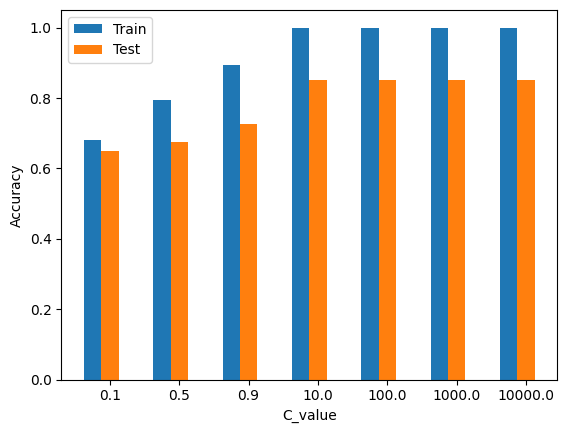

In [39]:
import pandas as pd 
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(C_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("C_value")
plt.ylabel("Accuracy")
plt.show()

In [40]:
# Creamos clasificador SVM
svc = svm.SVC(C = 10.0, gamma=10, max_iter=1000) 
# Entrenamos modelo
svc.fit(Xtrain_100, ytrain_100.ravel())

accTest = svc.score(Xtest_100, ytest_100.ravel())
accTrain = svc.score(Xtrain_100, ytrain_100.ravel())

print("Precisión en test: {}".format(accTest*100))
print("Precisión en test: {}".format(accTrain*100))

Precisión en test: 100.0
Precisión en test: 100.0


In [41]:
gamma_values = [0.1, 0.5, 0.9, 10, 100, 1000]
accuaraciesTrain = []
accuaraciesTest = []

for gamma in (gamma_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = 10.0, gamma=gamma, max_iter=1000)
    # Entrenamos modelo
    svc.fit(Xtrain_100, ytrain_100.ravel())
    accTest = svc.score(Xtest_100, ytest_100.ravel())
    accTrain = svc.score(Xtrain_100, ytrain_100.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", gamma_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000]
Precisión en train   :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Precisión en test   :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


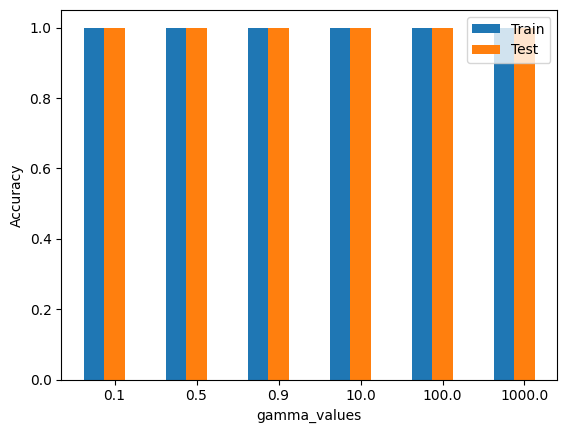

In [42]:
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(gamma_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("gamma_values")
plt.ylabel("Accuracy")
plt.show()

#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

##### SVM SIN PARÁMETROS

In [43]:
# Creamos clasificador SVM
svc = svm.SVC() 
# Entrenamos modelo
svc.fit(Xtrain_500, ytrain_500.ravel())

accTest = svc.score(Xtest_500, ytest_500.ravel())
accTrain = svc.score(Xtrain_500, ytrain_500.ravel())

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 86.5
Precisión en train: 95.0


#### SVM CON PARÁMETROS

In [45]:
C_values = [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
accuaraciesTrain = []
accuaraciesTest = []

for c in (C_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = c)
    # Entrenamos modelo
    svc.fit(Xtrain_500, ytrain_500.ravel())
    accTest = svc.score(Xtest_500, ytest_500.ravel())
    accTrain = svc.score(Xtrain_500, ytrain_500.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", C_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
Precisión en train   :  [0.645, 0.822, 0.943, 1.0, 1.0, 1.0, 1.0]
Precisión en test   :  [0.695, 0.8, 0.86, 0.895, 0.895, 0.895, 0.895]


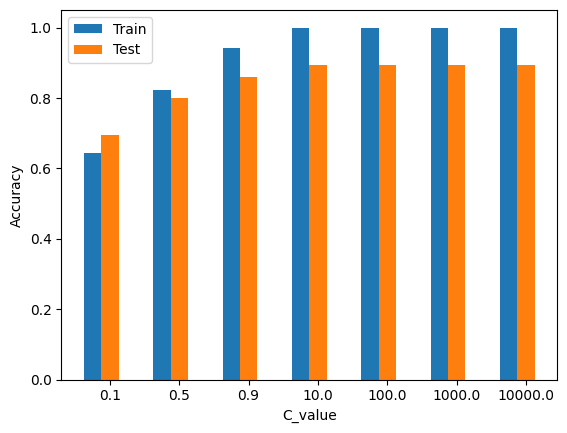

In [46]:
import pandas as pd 
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(C_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("C_value")
plt.ylabel("Accuracy")
plt.show()

In [47]:
gamma_values = [0.1, 0.5, 0.9, 10, 100, 1000]
accuaraciesTrain = []
accuaraciesTest = []

for gamma in (gamma_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = 10.0, gamma=gamma, max_iter=1000)
    # Entrenamos modelo
    svc.fit(Xtrain_500, ytrain_500.ravel())
    accTest = svc.score(Xtest_500, ytest_500.ravel())
    accTrain = svc.score(Xtrain_500, ytrain_500.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", gamma_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000]
Precisión en train   :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Precisión en test   :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


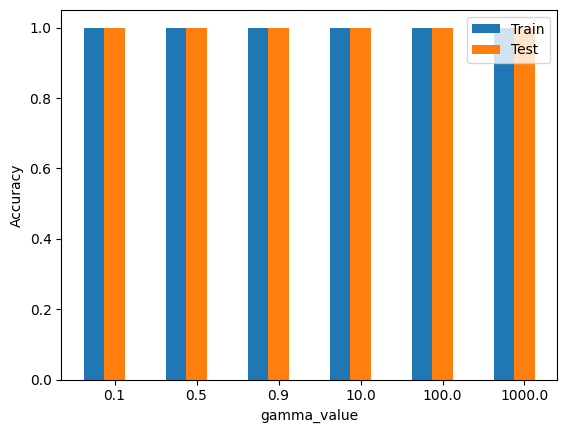

In [48]:
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(gamma_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("gamma_value")
plt.ylabel("Accuracy")
plt.show()

#### 1.2.LOGISTIC REGRESSION

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

In [80]:
regr = LogisticRegression()
regr.fit(Xtrain_100, ytrain_100)
accTest = regr.score(Xtest_100, ytest_100)
accTrain = regr.score(Xtrain_100, ytrain_100)
print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 85.0
Precisión en train: 100.0


#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

In [81]:
regr = LogisticRegression()
regr.fit(Xtrain_500, ytrain_500)
accTest = regr.score(Xtest_500, ytest_500)
accTrain = regr.score(Xtrain_500, ytrain_500)
print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

C:\Users\danim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisión en test: 85.0
Precisión en train: 100.0


#### 1.3.REDES NEURONALES

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

In [82]:
clf = MLPClassifier()
clf.fit(Xtrain_100, ytrain_100)
accTrain = clf.score(Xtrain_100, ytrain_100)
accTest = clf.score(Xtest_100, ytest_100)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 92.5
Precisión en train: 100.0


#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

In [52]:
clf = MLPClassifier()
clf.fit(Xtrain_500, ytrain_500)
accTrain = clf.score(Xtrain_500, ytrain_500)
accTest = clf.score(Xtest_500, ytest_500)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 50.0
Precisión en train: 50.0


#### 1.4. ADABOOST CON DECISION STUMP

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

In [53]:
numClasificadoresBase = 30
adaboost = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=numClasificadoresBase, random_state=12)
adaboost.fit(Xtrain_100, ytrain_100)

accTrain = adaboost.score(Xtrain_100, ytrain_100)
accTest = adaboost.score(Xtest_100, ytest_100)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 82.5
Precisión en train: 100.0


#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

In [54]:
numClasificadoresBase = 30
adaboost = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=numClasificadoresBase, random_state=12)
adaboost.fit(Xtrain_500, ytrain_500)

accTrain = adaboost.score(Xtrain_500, ytrain_500)
accTest = adaboost.score(Xtest_500, ytest_500)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 72.5
Precisión en train: 86.6


Leemos datos de la segunda extracción

In [55]:
datasets_2

['datasets_2_txt/cat_100_test_2.txt',
 'datasets_2_txt/cat_100_train_2.txt',
 'datasets_2_txt/cat_500_test_2.txt',
 'datasets_2_txt/cat_500_train_2.txt',
 'datasets_2_txt/dog_100_test_2.txt',
 'datasets_2_txt/dog_100_train_2.txt',
 'datasets_2_txt/dog_500_test_2.txt',
 'datasets_2_txt/dog_500_train_2.txt']

Lectura de datos de los datasets con el segundo tipo de extracción de caracteristicas

In [84]:
(Xtrain_cat_100, Xtest_cat_100) = LeerDatos(datasets_2[0], datasets_2[1])
(Xtrain_cat_500, Xtest_cat_500) = LeerDatos(datasets_2[2], datasets_2[3])
(Xtrain_dog_100, Xtest_dog_100) = LeerDatos(datasets_2[4], datasets_2[5])
(Xtrain_dog_500, Xtest_dog_500) = LeerDatos(datasets_2[6], datasets_2[7])

In [85]:
Xtrain_100 = np.vstack((Xtrain_cat_100, Xtrain_dog_100))
ytrain_100 = np.hstack((np.ones(Xtrain_cat_100.shape[0]), np.zeros(Xtrain_dog_100.shape[0])))
Xtest_100 = np.vstack((Xtest_cat_100, Xtest_dog_100))
ytest_100 = np.hstack((np.ones(Xtest_cat_100.shape[0]), np.zeros(Xtest_dog_100.shape[0])))
Xtrain_500 = np.vstack((Xtrain_cat_500, Xtrain_dog_500))
ytrain_500 = np.hstack((np.ones(Xtrain_cat_500.shape[0]), np.zeros(Xtrain_dog_500.shape[0])))
Xtest_500 = np.vstack((Xtest_cat_500, Xtest_dog_500))
ytest_500 = np.hstack((np.ones(Xtest_cat_500.shape[0]), np.zeros(Xtest_dog_500.shape[0])))

In [58]:
print(Xtrain_100.shape)
print(ytrain_100.shape)
print(Xtest_100.shape)
print(ytest_100.shape)
print(Xtrain_500.shape)
print(ytrain_500.shape)
print(Xtest_500.shape)
print(ytest_500.shape)

(200, 5382)
(200,)
(40, 5382)
(40,)
(1000, 5382)
(1000,)
(200, 5382)
(200,)


## 2. COMPROBACIONES DATASETS DEL PRIMER TIPO DE EXTRACCIÓN DE CARACTERÍSTICAS

### 2. SVM CON EL SEGUNDO TIPO DE EXTRACCIÓN

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

##### SVM SIN PARÁMETROS

In [86]:
# Creamos clasificador SVM
svc = svm.SVC() 
# Entrenamos modelo
svc.fit(Xtrain_100, ytrain_100.ravel())

accTest = svc.score(Xtest_100, ytest_100.ravel())
accTrain = svc.score(Xtrain_100, ytrain_100.ravel())

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 57.49999999999999
Precisión en train: 66.0


##### SVM CON PARÁMETROS

In [60]:
C_values = [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
accuaraciesTrain = []
accuaraciesTest = []

for c in (C_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = c)
    # Entrenamos modelo
    svc.fit(Xtrain_100, ytrain_100.ravel())
    accTest = svc.score(Xtest_100, ytest_100.ravel())
    accTrain = svc.score(Xtrain_100, ytrain_100.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", C_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
Precisión en train   :  [0.645, 0.645, 0.66, 0.705, 0.705, 0.705, 0.705]
Precisión en test   :  [0.6, 0.6, 0.575, 0.6, 0.6, 0.6, 0.6]


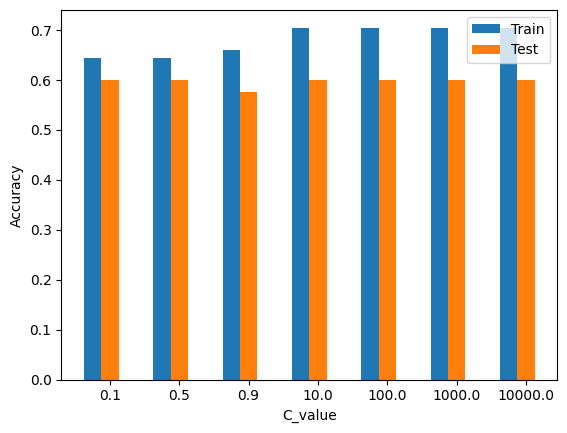

In [61]:
import pandas as pd 
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(C_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("C_value")
plt.ylabel("Accuracy")
plt.show()

In [89]:
gamma_values = [0.1, 0.5, 0.9, 10, 100, 1000]
accuaraciesTrain = []
accuaraciesTest = []

for gamma in (gamma_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = 10.0, gamma=gamma)
    # Entrenamos modelo
    svc.fit(Xtrain_100, ytrain_100.ravel())
    accTest = svc.score(Xtest_100, ytest_100.ravel())
    accTrain = svc.score(Xtrain_100, ytrain_100.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", gamma_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000]
Precisión en train   :  [0.705, 0.705, 0.705, 0.705, 0.705, 0.705]
Precisión en test   :  [0.6, 0.65, 0.65, 0.7, 0.7, 0.7]


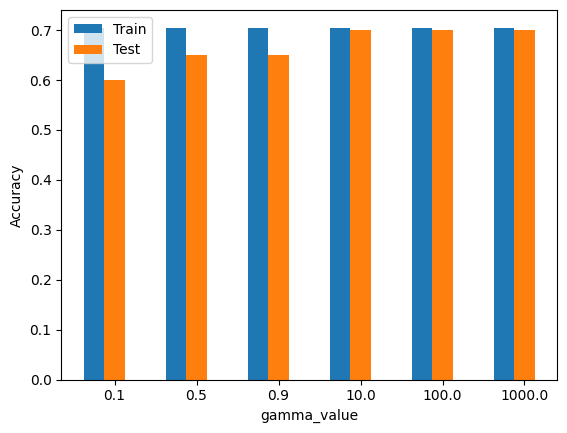

In [63]:
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(gamma_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("gamma_value")
plt.ylabel("Accuracy")
plt.show()

#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

##### SVM SIN PARÁMETROS

In [64]:
# Creamos clasificador SVM
svc = svm.SVC() 
# Entrenamos modelo
svc.fit(Xtrain_500, ytrain_500.ravel())

accTest = svc.score(Xtest_500, ytest_500.ravel())
accTrain = svc.score(Xtrain_500, ytrain_500.ravel())

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 59.5
Precisión en train: 64.0


##### SVM CON PARÁMETROS

In [65]:
C_values = [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
accuaraciesTrain = []
accuaraciesTest = []

for c in (C_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = c)
    # Entrenamos modelo
    svc.fit(Xtrain_500, ytrain_500.ravel())
    accTest = svc.score(Xtest_500, ytest_500.ravel())
    accTrain = svc.score(Xtrain_500, ytrain_500.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", C_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000, 10000]
Precisión en train   :  [0.528, 0.577, 0.637, 0.693, 0.694, 0.694, 0.694]
Precisión en test   :  [0.535, 0.555, 0.6, 0.635, 0.625, 0.625, 0.625]


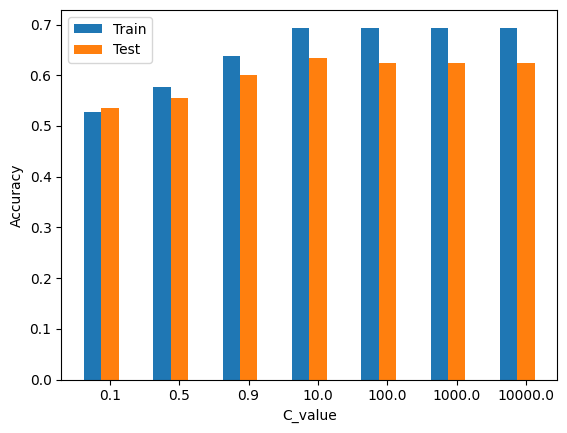

In [66]:
 data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(C_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("C_value")
plt.ylabel("Accuracy")
plt.show()

In [67]:
gamma_values = [0.1, 0.5, 0.9, 10, 100, 1000]
accuaraciesTrain = []
accuaraciesTest = []

for gamma in (gamma_values):
    # Creamos clasificador SVM
    svc = svm.SVC(C = 100.0, gamma=gamma)
    # Entrenamos modelo
    svc.fit(Xtrain_500, ytrain_500.ravel())
    accTest = svc.score(Xtest_500, ytest_500.ravel())
    accTrain = svc.score(Xtrain_500, ytrain_500.ravel())
    accuaraciesTrain.append(accTrain)
    accuaraciesTest.append(accTest)
print("Los valores de C son: ", gamma_values)
print("Precisión en train   : ", accuaraciesTrain)
print("Precisión en test   : ", accuaraciesTest)

Los valores de C son:  [0.1, 0.5, 0.9, 10, 100, 1000]
Precisión en train   :  [0.694, 0.694, 0.694, 0.694, 0.694, 0.694]
Precisión en test   :  [0.625, 0.675, 0.68, 0.73, 0.73, 0.73]


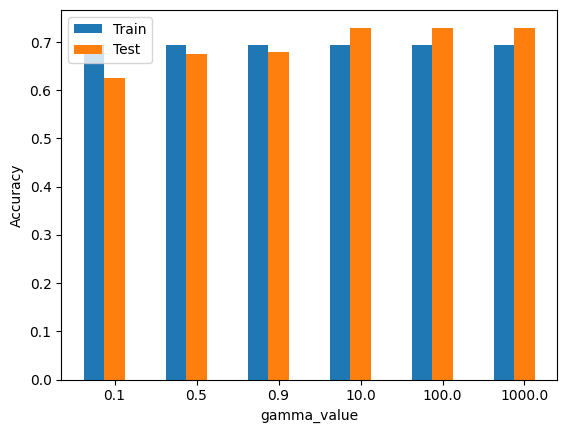

In [68]:
data = pd.DataFrame({'Train' : accuaraciesTrain,
                     'Test': accuaraciesTest},
                    index=(gamma_values))
n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Train, width=width, label='Train')
plt.bar(x, data.Test, width=width, label='Test')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.xlabel("gamma_value")
plt.ylabel("Accuracy")
plt.show()

#### 2.2. LOGISTIC REGRESSION

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

In [69]:
regr = LogisticRegression()
regr.fit(Xtrain_100, ytrain_100)
accTest = regr.score(Xtest_100, ytest_100)
accTrain = regr.score(Xtrain_100, ytrain_100)
print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 60.0
Precisión en train: 70.5


#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

In [70]:
regr = LogisticRegression()
regr.fit(Xtrain_500, ytrain_500)
accTest = regr.score(Xtest_500, ytest_500)
accTrain = regr.score(Xtrain_500, ytrain_500)
print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 62.0
Precisión en train: 68.8


#### 2.3. REDES NEURONALES

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

In [71]:
clf = MLPClassifier()
clf.fit(Xtrain_100, ytrain_100)
accTrain = clf.score(Xtrain_100, ytrain_100)
accTest = clf.score(Xtest_100, ytest_100)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 62.5
Precisión en train: 70.5


#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

In [72]:
clf = MLPClassifier()
clf.fit(Xtrain_500, ytrain_500)
accTrain = clf.score(Xtrain_500, ytrain_500)
accTest = clf.score(Xtest_500, ytest_500)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 61.0
Precisión en train: 69.39999999999999


#### 2.4. ADABOOST CON DECISION STUMP

#### 200 EJEMPLOS EN TRAIN Y 40 EJEMPLOS EN TEST

In [73]:
numClasificadoresBase = 30
adaboost = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=numClasificadoresBase, random_state=12)
adaboost.fit(Xtrain_100, ytrain_100)

accTrain = adaboost.score(Xtrain_100, ytrain_100)
accTest = adaboost.score(Xtest_100, ytest_100)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 57.49999999999999
Precisión en train: 70.0


#### 1000 EJEMPLOS EN TRAIN Y 200 EJEMPLOS EN TEST

In [74]:
numClasificadoresBase = 30
adaboost = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=numClasificadoresBase, random_state=12)
adaboost.fit(Xtrain_500, ytrain_500)

accTrain = adaboost.score(Xtrain_500, ytrain_500)
accTest = adaboost.score(Xtest_500, ytest_500)

print("Precisión en test: {}".format(accTest*100))
print("Precisión en train: {}".format(accTrain*100))

Precisión en test: 53.0
Precisión en train: 59.599999999999994
